In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   GLDD    1259 non-null   float64
 3   HSON    1259 non-null   float64
 4   ISSC    1259 non-null   float64
 5   KRNT    1259 non-null   float64
 6   RCII    1259 non-null   float64
 7   SAIA    1259 non-null   float64
 8   AMD     1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  APPS    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  AUDC    1259 non-null   float64
 13  DSGX    1259 non-null   float64
 14  TTD     1259 non-null   float64
 15  TSLA    1259 non-null   float64
 16  CHDN    1259 non-null   float64
 17  CLAR    1259 non-null   float64
 18  FIVE    1259 non-null   float64
 19  FOXF    1259 non-null   float64
 20  HTHT    1259 non-null   float64
 21  LULU    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.0287595,0.209272,0.0153755,0.031024,0.004788,0.031346,0.0284165,0.001022,0.031924,
               0.040128,0.125024,0.0766,0.062668,0.00456,0.0591,0.030421,0.008134,0.021438,0.003633,
               0.00768,0.004057,0.024637,0.046948,0.008054,0.0251,0.001736,0.016118,0.005158,0.04317,
               0.045068,0.008652,0.15,0]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-09,2.681372,11.705958,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.366807,2.682155,...,0.006093,1.295404,0.184244,0.102313,1.457499,0.044558,15.155844,0.0,55.490416,-0.001133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.201777,41.328464,0.192194,0.333198,0.031505,2.772554,1.059763,0.189550,2.930942,14.299211,...,0.008819,3.102876,0.717684,1.363309,8.819357,0.374199,40.847054,0.0,231.240637,0.009093
2020-12-28,5.262458,40.632185,0.196191,0.325132,0.030883,2.856874,1.060040,0.186852,2.924238,14.190465,...,0.008715,3.084663,0.712887,1.390506,8.428618,0.386917,41.029742,0.0,229.174589,-0.008935
2020-12-29,5.233522,40.469586,0.199113,0.319237,0.030739,2.796377,1.053375,0.186341,2.892953,14.115024,...,0.008593,3.118833,0.711133,1.341292,8.518754,0.378612,40.992609,0.0,228.621210,-0.002415


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-09,2.681372,11.705958,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.366807,2.682155,...,0.006093,1.295404,0.184244,0.102313,1.457499,0.044558,15.155844,0.0,55.490416,-0.001133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.201777,41.328464,0.192194,0.333198,0.031505,2.772554,1.059763,0.189550,2.930942,14.299211,...,0.008819,3.102876,0.717684,1.363309,8.819357,0.374199,40.847054,0.0,231.240637,0.009093
2020-12-28,5.262458,40.632185,0.196191,0.325132,0.030883,2.856874,1.060040,0.186852,2.924238,14.190465,...,0.008715,3.084663,0.712887,1.390506,8.428618,0.386917,41.029742,0.0,229.174589,-0.008935
2020-12-29,5.233522,40.469586,0.199113,0.319237,0.030739,2.796377,1.053375,0.186341,2.892953,14.115024,...,0.008593,3.118833,0.711133,1.341292,8.518754,0.378612,40.992609,0.0,228.621210,-0.002415


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-07,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,5.201777,41.328464,0.192194,0.333198,0.031505,2.772554,1.059763,0.189550,2.930942,14.299211,...,0.008819,3.102876,0.717684,1.363309,8.819357,0.374199,40.847054,0.0,231.240637,0.009093
2020-12-28,5.262458,40.632185,0.196191,0.325132,0.030883,2.856874,1.060040,0.186852,2.924238,14.190465,...,0.008715,3.084663,0.712887,1.390506,8.428618,0.386917,41.029742,0.0,229.174589,-0.008935
2020-12-29,5.233522,40.469586,0.199113,0.319237,0.030739,2.796377,1.053375,0.186341,2.892953,14.115024,...,0.008593,3.118833,0.711133,1.341292,8.518754,0.378612,40.992609,0.0,228.621210,-0.002415


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,55.464930
2017-01-04,55.693958
2017-01-05,55.418841
2017-01-06,55.553335
2017-01-07,55.553335
...,...
2020-12-27,231.240637
2020-12-28,229.174589
2020-12-29,228.621210


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Observations : 1459


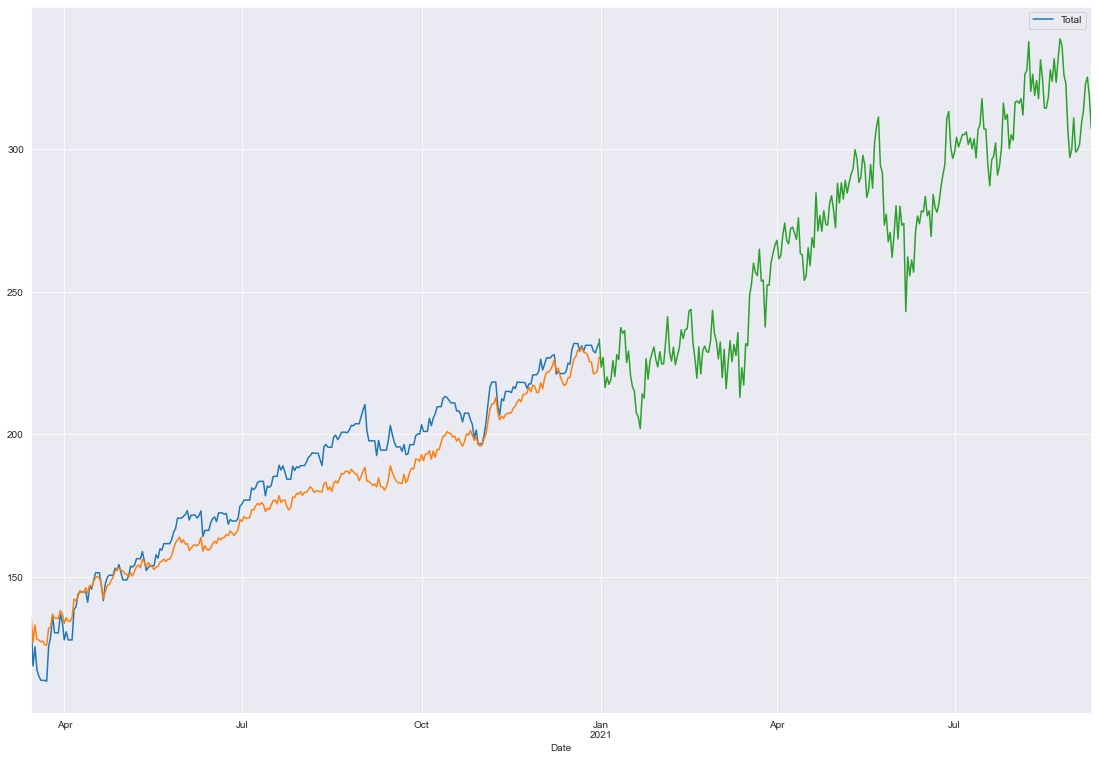

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2020-12-31    233.400791
2021-01-01    223.586252
2021-01-02    226.959755
2021-01-03    216.404192
2021-01-04    220.111229
                 ...    
2021-09-05    313.529618
2021-09-06    322.738235
2021-09-07    325.206097
2021-09-08    318.516388
2021-09-09    307.164792
Freq: D, Length: 253, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2020-12-31,233.400791
2021-01-01,223.586252
2021-01-02,226.959755
2021-01-03,216.404192
2021-01-04,220.111229
...,...
2021-09-05,313.529618
2021-09-06,322.738235
2021-09-07,325.206097
2021-09-08,318.516388


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.042050
2021-01-02,-0.027596
2021-01-03,-0.072822
2021-01-04,-0.056939
...,...
2021-09-05,0.343310
2021-09-06,0.382764
2021-09-07,0.393338
2021-09-08,0.364676


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  31.604006


## Backtesting

In [27]:
tickers2 = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [28]:
panel_data2 = panel_data2['Adj Close']

In [29]:
panel_data2

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,184.110870,193.298798,13.06,10.750000,6.49,90.000000,37.959911,182.320007,92.290001,358.480011,...,4.27,11.640000,5.25,193.660004,137.860001,31.200001,189.139999,44.540001,273.358856,0.370
2020-12-31,185.455048,194.856201,13.17,10.500000,6.52,89.129997,37.870899,180.800003,91.709999,358.350006,...,4.20,11.540000,5.17,194.979996,139.199997,31.160000,191.630005,44.130001,280.895782,0.361
2021-01-04,177.036865,190.373672,12.96,10.420000,6.30,81.769997,37.722538,179.929993,92.300003,348.059998,...,4.29,11.860000,5.12,192.020004,134.419998,33.360001,190.660004,39.820000,274.424225,0.354
2021-01-05,178.910843,191.431915,13.29,10.540000,6.55,85.199997,39.265465,180.860001,92.769997,345.700012,...,4.44,12.920000,5.25,195.690002,133.990005,34.590000,194.669998,40.070000,271.387512,0.377
2021-01-06,179.322922,192.979340,14.36,10.360000,6.33,84.480003,43.004093,187.009995,90.330002,329.660004,...,4.50,13.280000,5.64,205.479996,139.880005,35.410000,197.009995,40.119999,263.482300,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,208.259995,348.309998,15.84,27.400000,6.45,143.660004,48.139999,323.529999,146.139999,663.080017,...,3.22,29.540001,5.65,307.929993,223.369995,60.490002,264.649994,23.320000,374.279999,1.243
2021-12-27,210.330002,355.600006,15.75,27.850000,6.41,153.360001,49.200001,333.049988,154.360001,697.000000,...,3.15,30.270000,5.40,307.619995,227.899994,63.349998,267.859985,22.049999,383.359985,1.252
2021-12-28,212.160004,356.640015,15.64,28.180000,6.60,152.449997,48.930000,330.190002,153.149994,682.200012,...,3.11,29.280001,5.50,306.049988,218.300003,60.730000,253.770004,21.940001,384.730011,1.245


## Portfolio Analysis

In [30]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.007301,0.008057,0.008423,-0.023256,0.004623,-0.009667,-0.002345,-0.008337,-0.006285,-0.000363,...,-0.016393,-0.008591,-0.015238,0.006816,0.009720,-0.001282,0.013165,-0.009205,0.027572,-0.024324
2021-01-04,-0.045392,-0.023004,-0.015945,-0.007619,-0.033742,-0.082576,-0.003918,-0.004812,0.006433,-0.028715,...,0.021429,0.027730,-0.009671,-0.015181,-0.034339,0.070603,-0.005062,-0.097666,-0.023039,-0.019391
2021-01-05,0.010585,0.005559,0.025463,0.011516,0.039683,0.041947,0.040902,0.005169,0.005092,-0.006780,...,0.034965,0.089376,0.025391,0.019113,-0.003199,0.036870,0.021032,0.006278,-0.011066,0.064972
2021-01-06,0.002303,0.008083,0.080512,-0.017078,-0.033588,-0.008451,0.095214,0.034004,-0.026302,-0.046399,...,0.013514,0.027864,0.074286,0.050028,0.043958,0.023706,0.012020,0.001248,-0.029129,0.145889
2021-01-07,-0.008317,0.044801,0.018802,0.021236,-0.028436,0.034564,-0.000690,0.036790,0.053471,0.026755,...,0.082222,-0.003012,0.003546,0.019321,0.000143,0.059023,0.035937,0.024427,0.002305,0.050926


In [31]:
portfolio_weights = [0.0287595,0.209272,0.0153755,0.031024,0.004788,0.031346,0.0284165,0.001022,0.031924,
               0.040128,0.125024,0.0766,0.062668,0.00456,0.0591,0.030421,0.008134,0.021438,0.003633,
               0.00768,0.004057,0.024637,0.046948,0.008054,0.0251,0.001736,0.016118,0.005158,0.04317,
               0.045068,0.008652,0.15,0]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000210,0.001686,0.000130,-0.000721,0.000022,-0.000303,-0.000067,-0.000009,-0.000201,-0.000015,...,-0.000132,-0.000216,-0.000026,0.000110,5.013565e-05,-0.000055,0.000593,-0.000080,0.004136,-0.0
2021-01-04,-0.001305,-0.004814,-0.000245,-0.000236,-0.000162,-0.002588,-0.000111,-0.000005,0.000205,-0.001152,...,0.000173,0.000696,-0.000017,-0.000245,-1.771209e-04,0.003048,-0.000228,-0.000845,-0.003456,-0.0
2021-01-05,0.000304,0.001163,0.000392,0.000357,0.000190,0.001315,0.001162,0.000005,0.000163,-0.000272,...,0.000282,0.002243,0.000044,0.000308,-1.649979e-05,0.001592,0.000948,0.000054,-0.001660,0.0
2021-01-06,0.000066,0.001692,0.001238,-0.000530,-0.000161,-0.000265,0.002706,0.000035,-0.000840,-0.001862,...,0.000109,0.000699,0.000129,0.000806,2.267379e-04,0.001023,0.000542,0.000011,-0.004369,0.0
2021-01-07,-0.000239,0.009376,0.000289,0.000659,-0.000136,0.001083,-0.000020,0.000038,0.001707,0.001074,...,0.000662,-0.000076,0.000006,0.000311,7.370841e-07,0.002548,0.001620,0.000211,0.000346,0.0


In [32]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31    0.003017
2021-01-04   -0.021403
2021-01-05    0.014800
2021-01-06   -0.009129
2021-01-07    0.035125
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,74.4%
Cumulative returns,74.4%
Annual volatility,28.8%
Sharpe ratio,2.08
Calmar ratio,5.44
Stability,0.93
Max drawdown,-13.7%


None


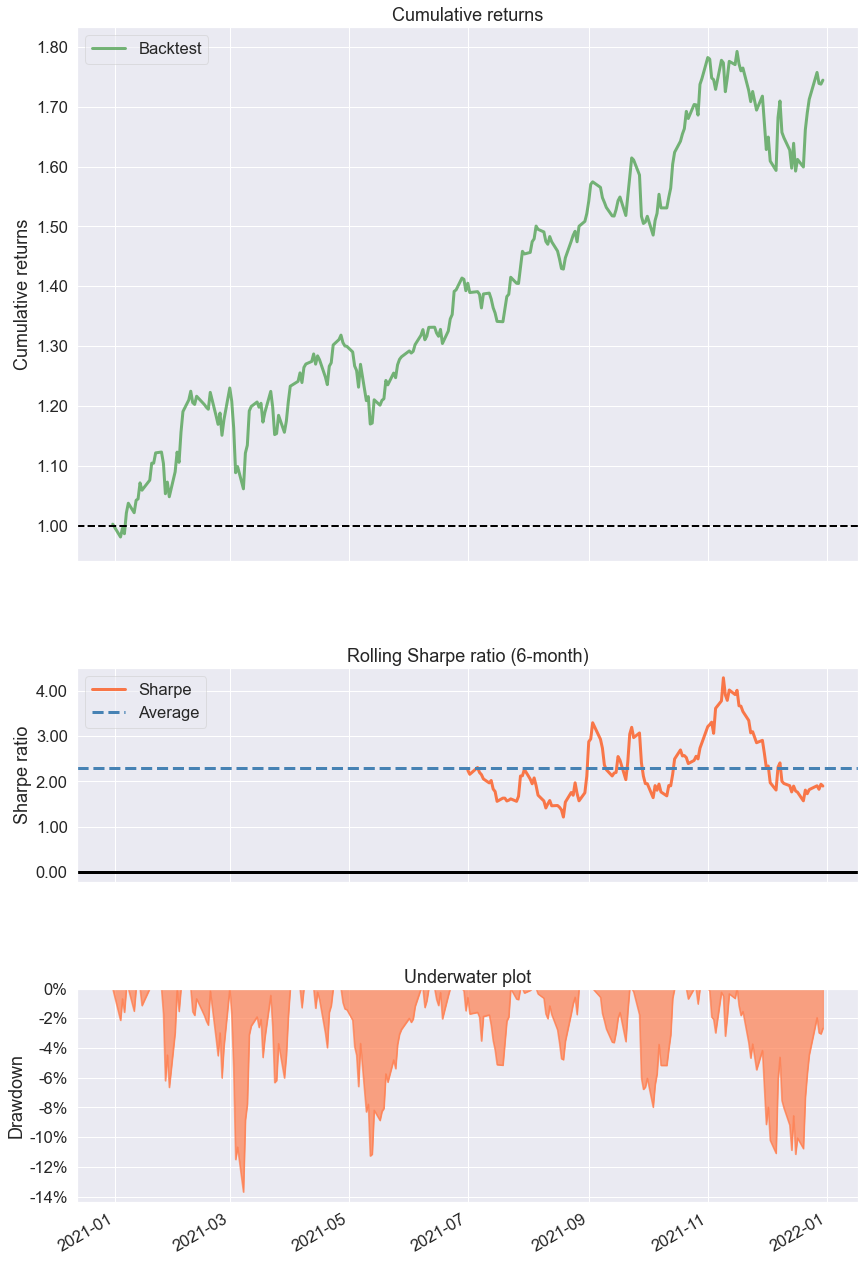

In [33]:
import pyfolio as pf
print(pf.create_simple_tear_sheet(portfolio_returns1))

## Extra stuff

In [34]:
import itertools

In [35]:
weights = [0.0287595,0.209272,0.0153755,0.031024,0.004788,0.031346,0.0284165,0.001022,0.031924,
               0.040128,0.125024,0.0766,0.062668,0.00456,0.0591,0.030421,0.008134,0.021438,0.003633,
               0.00768,0.004057,0.024637,0.046948,0.008054,0.0251,0.001736,0.016118,0.005158,0.04317,
               0.045068,0.008652,0.15,0]

In [36]:
panel_data2 = panel_data2 * weights

In [37]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [38]:
#forecasted portfolio value
panel_data2

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,5.294937,40.452026,0.200804,0.333508,0.031074,2.821140,1.078688,0.186331,2.946266,14.385086,...,0.292164,0.009114,3.121412,0.711082,1.346904,8.524161,0.385360,41.003828,0.0,231.198974
2020-12-31,5.333594,40.777947,0.202495,0.325752,0.031218,2.793869,1.076158,0.184778,2.927750,14.379869,...,0.289654,0.008975,3.142688,0.717994,1.345177,8.636381,0.381813,42.134367,0.0,232.817543
2021-01-04,5.091492,39.839879,0.199266,0.323270,0.030164,2.563162,1.071943,0.183888,2.946585,13.966952,...,0.297686,0.008888,3.094978,0.693338,1.440151,8.592665,0.344523,41.163634,0.0,230.668785
2021-01-05,5.145386,40.061340,0.204340,0.326993,0.031361,2.670679,1.115787,0.184839,2.961589,13.872250,...,0.324292,0.009114,3.154131,0.691120,1.493250,8.773387,0.346686,40.708127,0.0,232.192049
2021-01-06,5.157238,40.385172,0.220792,0.321409,0.030308,2.648110,1.222026,0.191124,2.883695,13.228597,...,0.333328,0.009791,3.311927,0.721501,1.528650,8.878846,0.347118,39.522345,0.0,229.382002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,5.989453,72.891530,0.243548,0.850058,0.030883,4.503166,1.367970,0.330648,4.665373,26.608075,...,0.741454,0.009808,4.963216,1.152142,2.611353,11.927246,0.201765,56.142000,0.0,349.600651
2021-12-27,6.048986,74.417124,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.927789,27.969216,...,0.759777,0.009374,4.958219,1.175508,2.734819,12.071914,0.190777,57.503998,0.0,357.435212
2021-12-28,6.101616,74.634769,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.889160,27.375322,...,0.734928,0.009548,4.932914,1.125991,2.621714,11.436907,0.189825,57.709502,0.0,355.219673


In [39]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [40]:
actual_portfolio_value

[231.19897427975414,
 232.81754303749562,
 230.668784558538,
 232.19204887042952,
 229.38200227680065,
 236.2352965660633,
 241.42439310854485,
 236.8729191716842,
 238.70118753520057,
 239.06620593434334,
 243.0254130486417,
 241.53403791170027,
 244.57524107460262,
 247.89217090513947,
 248.58185691944072,
 248.59652675543117,
 250.1271427447772,
 246.02506250439833,
 236.8949275203896,
 240.5258906941672,
 235.62720665972859,
 243.68837087861488,
 249.44233536847258,
 243.94814601330327,
 249.29486938159653,
 252.5803536099529,
 254.47373081935885,
 255.70063189896112,
 252.91028505735878,
 255.42674835022157,
 258.0030625006943,
 255.47020464381785,
 253.90363497728777,
 254.03703215519715,
 256.18737891343886,
 249.08608942080164,
 246.1929781224489,
 250.7463039692988,
 243.45517289019207,
 245.64514982664443,
 252.63763943733352,
 248.78059936946673,
 240.84445763900857,
 229.86437255117514,
 233.11601000247373,
 226.48240912502814,
 238.1566708530559,
 238.3418325010448,
 246.5

In [41]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [42]:
forecasted_portfolio_value

[233.40079147045938,
 223.58625184162395,
 226.95975491145683,
 216.40419176628026,
 220.11122919837754,
 217.56262306482665,
 219.26231158455445,
 225.85495196275758,
 220.32676810233977,
 227.94575990170705,
 226.19446809674798,
 237.4336495317758,
 235.41109712932388,
 236.39892569226265,
 225.1875086980287,
 229.20698107213062,
 220.77513619930951,
 216.68839550254808,
 215.13402563899808,
 207.5879599835141,
 206.0806119886518,
 202.02802576245392,
 214.20973329078802,
 212.70997416905334,
 226.51618903527213,
 219.3571619515331,
 225.82389015877058,
 228.4026209231623,
 230.65187477583407,
 226.191846362837,
 223.64945921488243,
 228.99837584172067,
 224.69443186493595,
 224.72987325319403,
 232.46263233658667,
 241.27847740450562,
 228.95379528905522,
 225.67818302279093,
 230.5511613849216,
 224.39389896597763,
 227.57790806085333,
 230.25421454555485,
 236.65353317519066,
 233.61469869954246,
 236.73816756913286,
 236.93283493408236,
 243.31514465260472,
 243.81997583568716,
 

## Calculate MAPE of forecasted period

In [43]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.08
MAPE % : 7.77 %



## Mean Squared Error

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(sqrt(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value)))

28.11998278613443


## Mean Average Error

In [45]:
from sklearn.metrics import mean_absolute_error as mae

#calculate MAE
mae(actual_portfolio_value, forecasted_portfolio_value)


23.22835404333149

## Forecast for future

In [46]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.0287595,0.209272,0.0153755,0.031024,0.004788,0.031346,0.0284165,0.001022,0.031924,
               0.040128,0.125024,0.0766,0.062668,0.00456,0.0591,0.030421,0.008134,0.021438,0.003633,
               0.00768,0.004057,0.024637,0.046948,0.008054,0.0251,0.001736,0.016118,0.005158,0.04317,
               0.045068,0.008652,0.15,0]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-09,2.681372,11.705958,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.366807,2.682155,...,0.006093,1.295404,0.184244,0.102313,1.457499,0.044558,15.155844,0.0,55.490416,-0.001133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.927789,27.969216,...,0.009374,4.958219,1.175508,2.734819,12.071914,0.190777,57.378337,0.0,357.182343,0.022411
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.889160,27.375322,...,0.009548,4.932914,1.125991,2.621714,11.436907,0.189825,57.583388,0.0,354.966107,-0.006205
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.733052,27.200365,...,0.009270,4.964183,1.137184,2.568183,11.623037,0.186018,57.616319,0.0,355.548112,0.001640


In [47]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-09,2.681372,11.705958,0.066883,0.434336,0.015440,0.418469,0.278048,0.045070,0.366807,2.682155,...,0.006093,1.295404,0.184244,0.102313,1.457499,0.044558,15.155844,0.0,55.490416,-0.001133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.927789,27.969216,...,0.009374,4.958219,1.175508,2.734819,12.071914,0.190777,57.378337,0.0,357.182343,0.022411
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.889160,27.375322,...,0.009548,4.932914,1.125991,2.621714,11.436907,0.189825,57.583388,0.0,354.966107,-0.006205
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.733052,27.200365,...,0.009270,4.964183,1.137184,2.568183,11.623037,0.186018,57.616319,0.0,355.548112,0.001640


In [48]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [49]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [50]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.696598,11.863168,0.069190,0.440541,0.014329,0.415334,0.299397,0.045888,0.364891,2.554548,...,0.005798,1.204176,0.185224,0.104903,1.403868,0.043000,15.529626,0.0,55.464930,NaN
2017-01-04,2.711299,11.912382,0.072265,0.456053,0.014452,0.404363,0.302483,0.046041,0.364891,2.582638,...,0.005885,1.238185,0.187700,0.103608,1.455696,0.041703,15.551699,0.0,55.693958,0.004129
2017-01-05,2.714712,11.771576,0.068728,0.452950,0.014905,0.391825,0.288337,0.044917,0.358826,2.598288,...,0.005868,1.228353,0.184811,0.104903,1.492202,0.042741,15.345676,0.0,55.418841,-0.004940
2017-01-06,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
2017-01-07,2.744638,11.770209,0.068421,0.446746,0.014823,0.396527,0.276505,0.045867,0.361380,2.683359,...,0.005920,1.267681,0.184760,0.104903,1.491751,0.042827,15.233836,0.0,55.553335,0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.022473,74.346030,0.242164,0.864018,0.030691,4.807223,1.398092,0.340377,4.927789,27.969216,...,0.009374,4.958219,1.175508,2.734819,12.071914,0.190777,57.378337,0.0,357.182343,0.022411
2021-12-28,6.074872,74.563464,0.240473,0.874256,0.031601,4.778698,1.390419,0.337454,4.889160,27.375322,...,0.009548,4.932914,1.125991,2.621714,11.436907,0.189825,57.583388,0.0,354.966107,-0.006205
2021-12-29,6.080885,75.435295,0.240780,0.870533,0.031314,4.839196,1.402638,0.342789,4.733052,27.200365,...,0.009270,4.964183,1.137184,2.568183,11.623037,0.186018,57.616319,0.0,355.548112,0.001640


In [51]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [52]:
tot_port_df

,Total
Date,
2017-01-03,55.464930
2017-01-04,55.693958
2017-01-05,55.418841
2017-01-06,55.553335
2017-01-07,55.553335
...,...
2021-12-27,357.182343
2021-12-28,354.966107
2021-12-29,355.548112


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


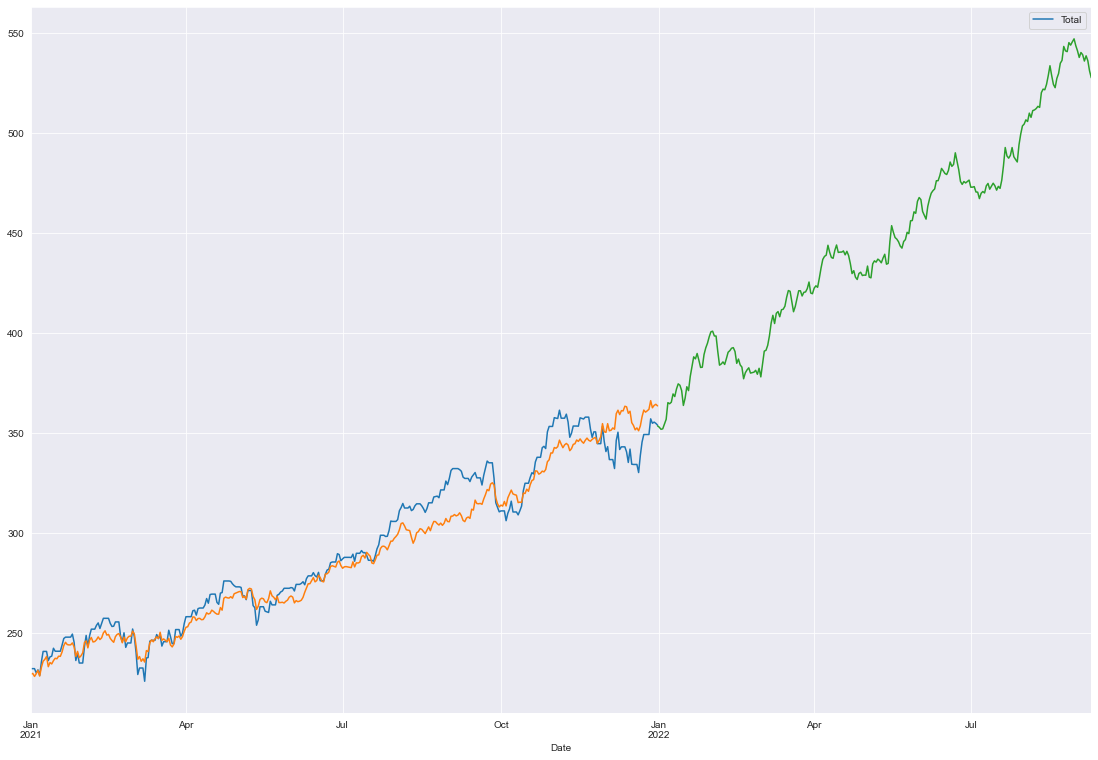

In [53]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [54]:
## Calculate annualized returns for forecasted

In [55]:
forecast

2021-12-31    353.663548
2022-01-01    352.994859
2022-01-02    351.950908
2022-01-03    352.178619
2022-01-04    354.577017
                 ...    
2022-09-05    536.038081
2022-09-06    538.654848
2022-09-07    536.196756
2022-09-08    531.092115
2022-09-09    527.682792
Freq: D, Length: 253, dtype: float64

In [56]:
forecast_df = pd.DataFrame(forecast)

In [57]:
forecast_df

,0
2021-12-31,353.663548
2022-01-01,352.994859
2022-01-02,351.950908
2022-01-03,352.178619
2022-01-04,354.577017
...,...
2022-09-05,536.038081
2022-09-06,538.654848
2022-09-07,536.196756
2022-09-08,531.092115


In [58]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [59]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.001891
2022-01-02,-0.004843
2022-01-03,-0.004199
2022-01-04,0.002583
...,...
2022-09-05,0.515672
2022-09-06,0.523071
2022-09-07,0.516121
2022-09-08,0.501687


In [60]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  49.204744
